In [2]:
#Importing the required libraries
##########################################################################################

import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from pandas.plotting import scatter_matrix
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, mean_squared_error, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline

In [3]:
#Read the data from CSV file into a Pandas DataFrame
##########################################################################################

data = pd.read_csv('Bank_data.csv')

In [4]:
#Removing all the unknowns that are not significant in number (< 10% data loss)
##########################################################################################

df = data[data.job != 'unknown']
df = df[df.marital != 'unknown']
df = df[df.education != 'unknown']
df = df[df.housing != 'unknown']
df = df[df.loan != 'unknown']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37144 entries, 0 to 39999
Data columns (total 20 columns):
id                37144 non-null int64
age               37144 non-null int64
job               37144 non-null object
marital           37144 non-null object
education         37144 non-null object
default           37144 non-null object
housing           37144 non-null object
loan              37144 non-null object
contact           37144 non-null object
month             37144 non-null object
day_of_week       37144 non-null object
pdays             37144 non-null int64
previous          37144 non-null int64
poutcome          37144 non-null object
emp.var.rate      37144 non-null float64
cons.price.idx    37144 non-null float64
cons.conf.idx     37144 non-null float64
euribor3m         37144 non-null float64
nr.employed       37144 non-null float64
y                 37144 non-null object
dtypes: float64(5), int64(4), object(11)
memory usage: 6.0+ MB


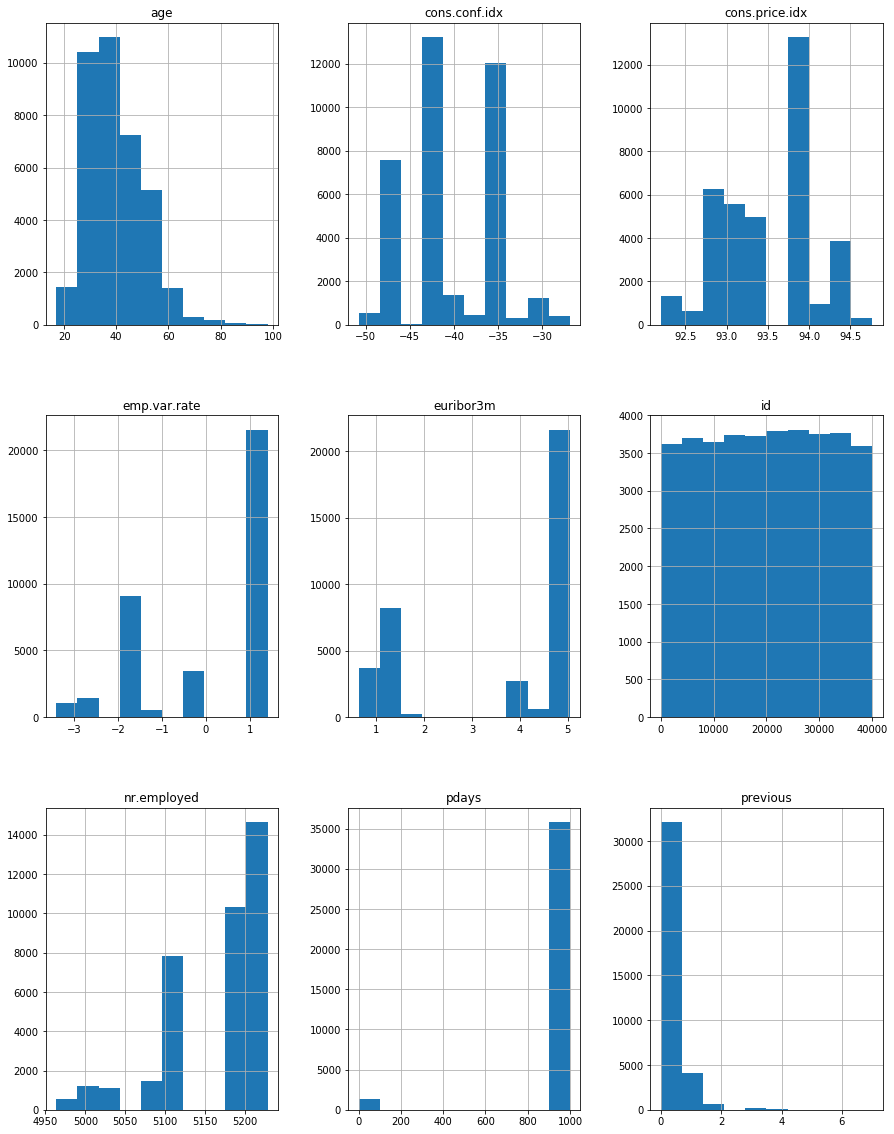

In [5]:
#Plotting the numerical data in form of histograms to get a better understanding
##########################################################################################

histograms = df.hist(figsize=[15,20])

In [6]:
#Binning the data in class 'Euribor3m' as we saw from the histograms above that it can be divided into 2 different classes
#Also finding and fixing any null values after the binning.
##########################################################################################

bins1 = [0, 2.5, 5]
labels1 = [0, 1]
df['euribor3m_bin'] = pd.cut(df['euribor3m'], bins=bins1, labels=labels1)
df[df.euribor3m_bin.isnull()] = 1
df.euribor3m_bin.value_counts()

1    24981
0    12163
Name: euribor3m_bin, dtype: int64

In [7]:
#Binning the data in class 'pdays' as we saw from the histograms above that it can be divided into 2 different classes: Contacted before and not contacted before.
#Also finding and fixing any null values after the binning.
##########################################################################################
#Binning 'pdays' reduced the performance so we will not bin this data
'''
bins = [0, 30, 1000]
labels = [1, 0]
df['pdays_bin'] = pd.cut(df['pdays'], bins=bins, labels=labels)
df[df.pdays_bin.isnull()] = 1
df.pdays_bin.value_counts()
'''

"\nbins = [0, 30, 1000]\nlabels = [1, 0]\ndf['pdays_bin'] = pd.cut(df['pdays'], bins=bins, labels=labels)\ndf[df.pdays_bin.isnull()] = 1\ndf.pdays_bin.value_counts()\n"

In [9]:
#Adding all numeric data in a DataFrame called 'df2' for further processing
##################################################################################################

#data.groupby('previous').size()
df2 = pd.concat([df['age'], df['pdays'], df['previous'], df['emp.var.rate'], df['cons.price.idx'], df['cons.conf.idx'], df['euribor3m_bin'], df['nr.employed']], axis = 1)

Looking at the histograms above, there are some features that have a clear peak and therefore should be scaled with a standard scaller (i.e. the mean will be zero and the standard deviation one). Other features fall off monotonically, and hence are better scaled with min-maxing, i.e. the minimum will be zero and the maximum one.

In [10]:
#Scaling the numeric data
# Appropriate methods of scaling was used for different variables based on their histograms
##################################################################################################

scaler = StandardScaler()
df2[['previous', 'emp.var.rate', 'nr.employed', 'pdays']] = scaler.fit_transform(df2[['previous', 'emp.var.rate', 'nr.employed', 'pdays']])

scaler = MinMaxScaler()
df2[['age', 'cons.price.idx', 'cons.conf.idx']] = scaler.fit_transform(df2[['age', 'cons.price.idx', 'cons.conf.idx']])

C:\Users\vip\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\vip\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\vip\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Now we have non numeric data which is in form of multiple classes. We will treat these classes as independent. For eg: the variable 'marital' has three different features. We will use One-Hot Encoding to process these variables.

In [11]:
#Making a list of all the non-numeric variables that we need to process using One-Hot Encoding
#One-Hot encoding is done using Pandas' get_dummies function
# All dummy variables were added to the DataFrame df2
##################################################################################################

list1 = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day_of_week', 'month', 'poutcome']

for feature in list1:
    df2_temp = pd.get_dummies(df[feature])
    #print(df2_temp)
    df2 = pd.concat([df2, df2_temp], axis=1)

In [12]:
#Checking the column list of our dataframe
##################################################################################################

df2.columns

Index([                'age',               'pdays',            'previous',
              'emp.var.rate',      'cons.price.idx',       'cons.conf.idx',
             'euribor3m_bin',         'nr.employed',                     1,
                    'admin.',         'blue-collar',        'entrepreneur',
                 'housemaid',          'management',             'retired',
             'self-employed',            'services',             'student',
                'technician',          'unemployed',                     1,
                  'divorced',             'married',              'single',
                           1,            'basic.4y',            'basic.6y',
                  'basic.9y',         'high.school',          'illiterate',
       'professional.course',   'university.degree',                     1,
                        'no',             'unknown',                 'yes',
                           1,                  'no',                 'yes',
            

In [13]:
# The '1's in the dataframe were added when fixing null values after binning and now we will remove them
# we will also remove unnecessary colums 'no', 'no', 'no', 'failure' as they convey no new information
##################################################################################################

df2 = df2.drop([1,1,1,1,1,1,1,1,1,1, 'no', 'no', 'no', 'failure'], axis=1)

In [14]:
df2.columns

Index(['age', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m_bin', 'nr.employed', 'admin.',
       'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired',
       'self-employed', 'services', 'student', 'technician', 'unemployed',
       'divorced', 'married', 'single', 'basic.4y', 'basic.6y', 'basic.9y',
       'high.school', 'illiterate', 'professional.course', 'university.degree',
       'unknown', 'yes', 'yes', 'yes', 'cellular', 'telephone', 'fri', 'mon',
       'thu', 'tue', 'wed', 'apr', 'aug', 'dec', 'jul', 'jun', 'mar', 'may',
       'nov', 'oct', 'sep', 'nonexistent', 'success'],
      dtype='object')

In [15]:
# One hot encoding of our target variable
##################################################################################################

y = pd.get_dummies(df['y'])

In [16]:
df3 = pd.concat([df2, y['yes']], axis = 1)

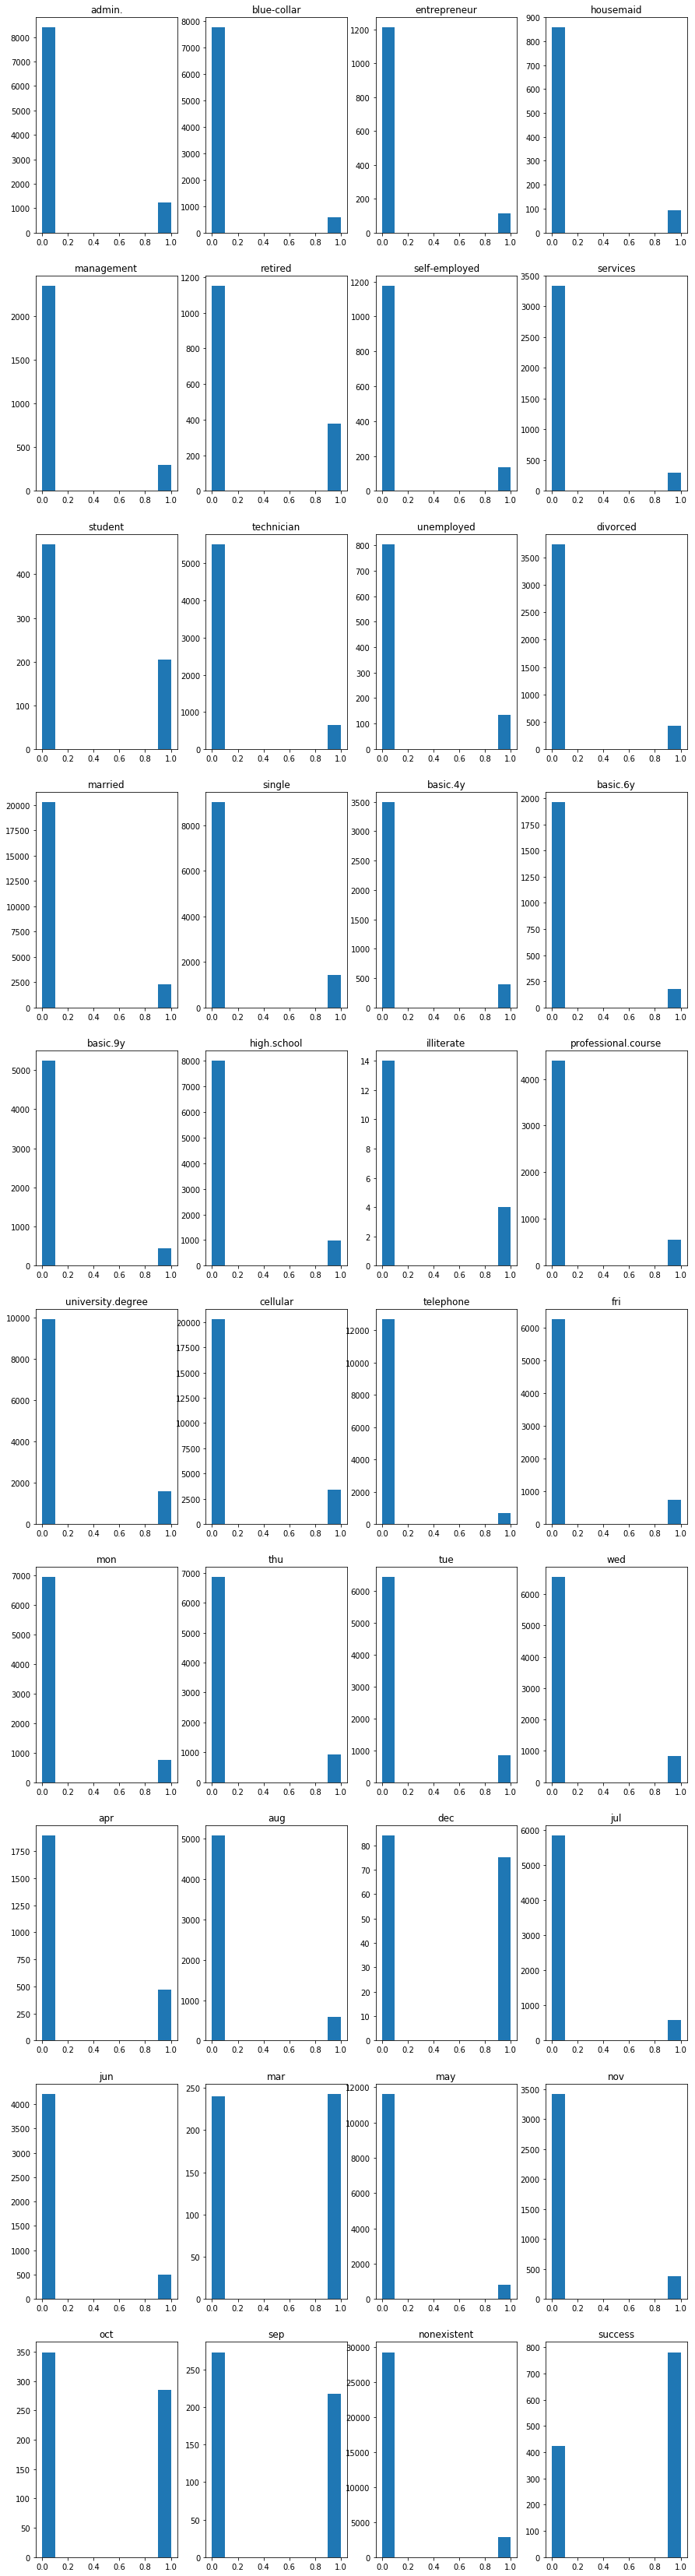

In [17]:
# Plotting histogram of all the one hot encoded features with output variable to see how individual feature effects our data.
##################################################################################################
list2 = ['admin.',
       'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired',
       'self-employed', 'services', 'student', 'technician', 'unemployed',
       'divorced', 'married', 'single', 'basic.4y', 'basic.6y', 'basic.9y',
       'high.school', 'illiterate', 'professional.course', 'university.degree',
        'cellular', 'telephone', 'fri', 'mon',
       'thu', 'tue', 'wed', 'apr', 'aug', 'dec', 'jul', 'jun', 'mar', 'may',
       'nov', 'oct', 'sep', 'nonexistent', 'success']

j = 1
plt.figure(figsize=(15,60))
for i in list2:
    plt.subplot(10, 4, j)
    j += 1
    plt.hist(df3[df3[i] == 1].iloc[:,-1])
    plt.title(i)
plt.show()

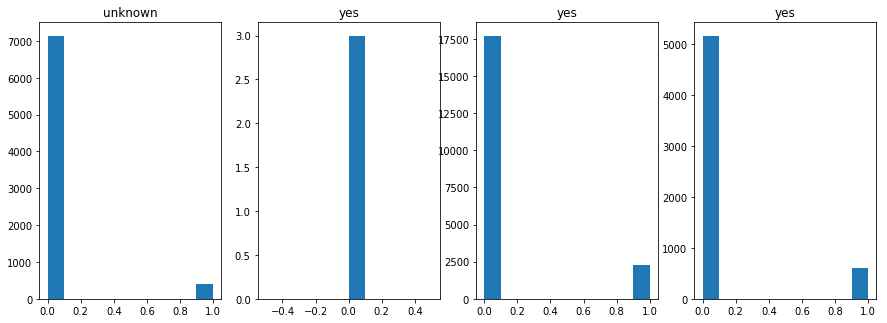

In [28]:
# Plotting remaining histograms of all remaining one hot encoded features with output variable to see how individual feature effects our data.
##################################################################################################

list3 = [29,30,31,32]
list4 = ['unknown', 'yes', 'yes', 'yes']

j = 1
plt.figure(figsize=(15,60))
for i in list3:
    plt.subplot(10, 4, j)
    plt.hist(df3[df3.iloc[:,i] == 1].iloc[:,-1])
    plt.title(list4[j-1])
    j += 1
plt.show()

In [18]:
## Correlaction Matrix
corr_mat = df3.corr()
print(corr_mat.iloc[:,-1].sort_values())

pdays                 -0.320018
emp.var.rate          -0.291312
nr.employed           -0.234570
nonexistent           -0.184714
telephone             -0.140731
may                   -0.104470
unknown               -0.094857
blue-collar           -0.071148
cons.price.idx        -0.047232
basic.9y              -0.045964
married               -0.041598
services              -0.032348
jul                   -0.029792
basic.6y              -0.022194
mon                   -0.019961
entrepreneur          -0.016088
nov                   -0.013761
aug                   -0.011447
divorced              -0.009253
basic.4y              -0.009121
fri                   -0.007857
jun                   -0.007677
housemaid             -0.006733
yes                   -0.006681
technician            -0.006444
self-employed         -0.004026
high.school           -0.003420
yes                   -0.003175
management             0.001329
professional.course    0.002504
wed                    0.005822
tue     

In [19]:
# Callign our training data array X
X = np.asarray(df2)

In [20]:
# Splitting our data into test and training set
##################################################################################################

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y['yes'], test_size=0.2)

In [21]:
# Defining our models
##################################################################################################

clf3 = RandomForestClassifier(n_estimators= 888,
 min_samples_split= 2,
 min_samples_leaf= 2,
 max_features= 'auto',
 max_depth= 10,
 bootstrap= False)

In [22]:
# Fitting our models
##################################################################################################

clf3.fit(X_train, y_train)
pred = clf3.predict(X_test)
y_test_prob = clf3.predict_proba(X_test)
y_test_pred = clf3.predict(X_test)

In [23]:
# Evaluating the accuracy score and AUC score on our models
# Calculating classification report
##################################################################################################

score = [accuracy_score(y_test, pred), roc_auc_score(y_test, y_test_prob[:,1])]
report = classification_report(pred, y_test)

In [24]:
#Printing the results
##################################################################################################

print('Accuracy:', score[0], 'AUC:', score[1], '\n', report)

Accuracy: 0.8987750706689999 AUC: 0.7901520464812116 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95      7171
           1       0.21      0.68      0.32       258

   micro avg       0.90      0.90      0.90      7429
   macro avg       0.60      0.79      0.63      7429
weighted avg       0.96      0.90      0.92      7429



In [36]:
# Feature importances from random forest
# Evaluating feature importances, sorting them and keeping most important features in list6
##################################################################################################

importances = clf3.feature_importances_
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(df2.columns, clf3.feature_importances_):
    feats[feature] = importance #add the name/value pair 

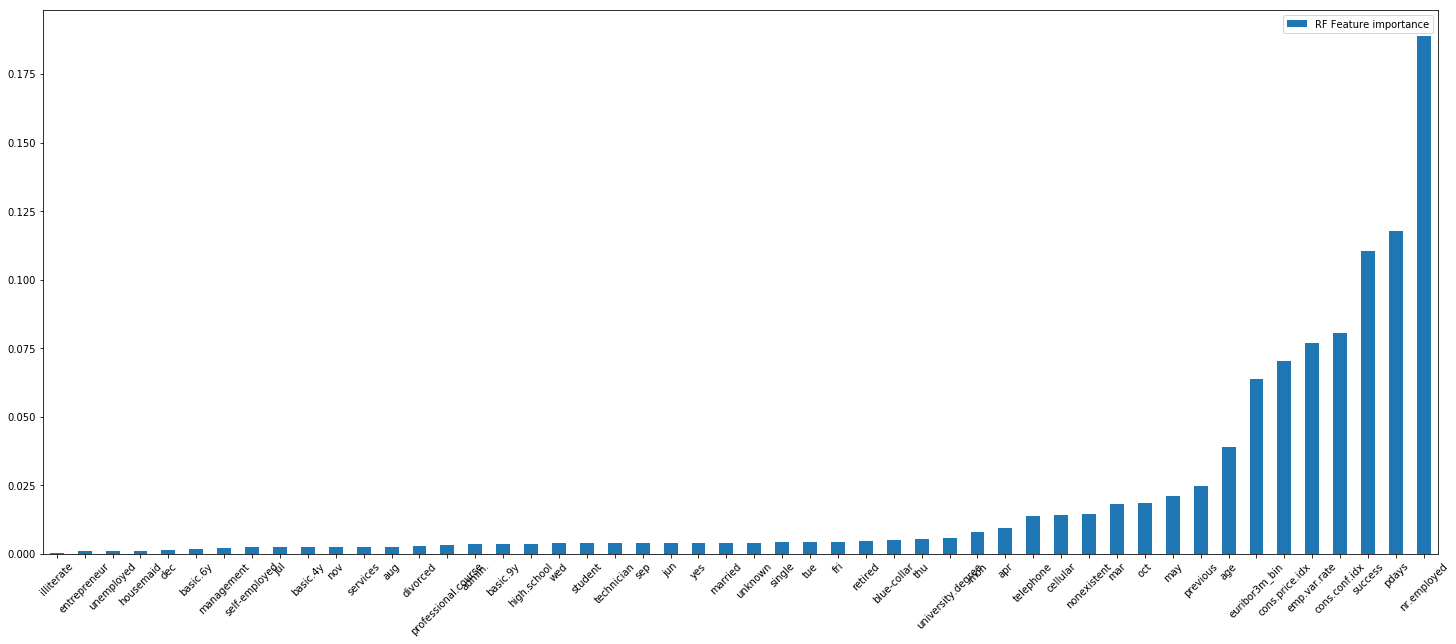

In [37]:
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'RF Feature importance'})
importances.sort_values(by='RF Feature importance').plot(kind='bar', rot=45, figsize = (25,10))

In [39]:
# Printing feature Importance (Sorted)
importances.sort_values(by='RF Feature importance')

,RF Feature importance
illiterate,0.000144
entrepreneur,0.000948
unemployed,0.000960
housemaid,0.001177
dec,0.001403
basic.6y,0.001721
management,0.002008
self-employed,0.002401
jul,0.002420
basic.4y,0.002433


In [40]:
# Using SVC
##################################################################################################

clf2 = SVC()
clf2.fit(X_train, y_train)
pred2 = clf2.predict(X_test)
score2 = [accuracy_score(y_test, pred), roc_auc_score(y_test, y_test_prob[:,1])]
report2 = classification_report(pred2, y_test)

C:\Users\vip\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [41]:
#Printing the results
##################################################################################################

print('Accuracy:', score2[0], 'AUC:', score2[1], '\n', report2)

Accuracy: 0.8987750706689999 AUC: 0.7901520464812116 
               precision    recall  f1-score   support

           0       0.99      0.90      0.94      7217
           1       0.17      0.69      0.28       212

   micro avg       0.90      0.90      0.90      7429
   macro avg       0.58      0.80      0.61      7429
weighted avg       0.97      0.90      0.93      7429



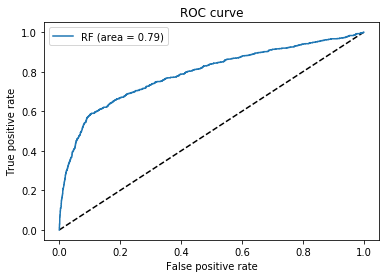

In [42]:
#ROC curve
##################################################################################################

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_prob[:,1], pos_label=1)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr_rf, tpr_rf, label='RF (area = {0:0.2f})'
         ''.format(roc_auc_rf))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig('ROC_curves_for_RFbest_bi.png', dip=400)


In [ ]:
#hyperparameter search (This part of the code is already executed in a seprate notebook and clf3 is optimized Random Forest)
##################################################################################################

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 500, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 60, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
# Fit the random search model
##################################################################################################

%%time
rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=3, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

In [ ]:
rf_random.best_params_